In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("test_pyspark") \
    .config("spark.driver.memory", "12g") \
    .config("spark.executor.memory", "12g") \
    .config("spark.sql.orc.enableVectorizedReader", "false") \
    .config("spark.sql.parquet.columnarReaderBatchSize", "1024") \
    .config("spark.sql.orc.columnarReaderBatchSize", "1024") \
    .getOrCreate()
spark.sparkContext.setLogLevel("ERROR")
spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/06 15:06:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/05/06 15:06:31 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/05/06 15:06:31 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
25/05/06 15:06:31 WARN Utils: Service 'SparkUI' could not bind on port 4042. Attempting port 4043.


In [ ]:
spark.sql("""
SELECT
  id,
  title,
  description,
  physicalDescription,
  lettering,
  referenceNumber,
  edition,

  -- Contributors information
  COALESCE(
    ARRAY_JOIN(
      TRANSFORM(
        contributors,
        c -> CONCAT(c.agent.label, ' (', COALESCE(c.roles[0].label, 'contributor'), ')')
      ),
      '; '
    ),
    ''
  ) AS contributor_names,

  -- Alternative titles
  COALESCE(ARRAY_JOIN(alternativeTitles, '; '), '') AS alternative_titles,

  -- Subjects
  COALESCE(
    ARRAY_JOIN(
      TRANSFORM(
        subjects,
        s -> s.label
      ),
      '; '
    ),
    ''
  ) AS subject_labels,

  -- Genres
  COALESCE(
    ARRAY_JOIN(
      TRANSFORM(
        genres,
        g -> g.label
      ),
      '; '
    ),
    ''
  ) AS genre_labels,

  -- Languages
  COALESCE(
    ARRAY_JOIN(
      TRANSFORM(
        languages,
        l -> l.label
      ),
      '; '
    ),
    ''
  ) AS language_labels,

  -- Production information
  COALESCE(
    ARRAY_JOIN(
      TRANSFORM(
        production,
        p -> p.label
      ),
      '; '
    ),
    ''
  ) AS production_info,

  -- Notes
  COALESCE(
    ARRAY_JOIN(
      TRANSFORM(
        notes,
        n -> ARRAY_JOIN(n.contents, ' ')
      ),
      '; '
    ),
    ''
  ) AS note_contents,

  -- Work type
  COALESCE(workType.label, '') AS work_type,

  -- Availability
  COALESCE(
    ARRAY_JOIN(
      TRANSFORM(
        availabilities,
        a -> a.label
      ),
      '; '
    ),
    ''
  ) AS availability_labels

FROM works
""").write.saveAsTable("works_text_flattened", mode="overwrite")

spark.table("works_text_flattened").show(truncate=False)

+--------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Text Analysis of Works Collection

In this section, we'll analyze the text fields in the `works_text_flattened` table to gain insights into the collection. We'll perform:

1. Basic text statistics (length, word count, etc.)
2. Visualize distribution of text length with histograms and boxplots
3. Apply text analysis techniques like term frequency, n-grams, and sentiment analysis
4. Explore relationships between different text fields
5. Apply novel text characterization methods

In [2]:
# Import necessary libraries for text analysis and visualization
import pyspark.sql.functions as F
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover

# Configure matplotlib for better display
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

In [3]:
# Load the works_text_flattened table
df = spark.table("works_text_flattened")

# Cache the table for faster processing
df.cache()

# Print schema to verify structure
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- description: string (nullable = true)
 |-- physicalDescription: string (nullable = true)
 |-- lettering: string (nullable = true)
 |-- referenceNumber: string (nullable = true)
 |-- edition: string (nullable = true)
 |-- contributor_names: string (nullable = true)
 |-- alternative_titles: string (nullable = true)
 |-- subject_labels: string (nullable = true)
 |-- genre_labels: string (nullable = true)
 |-- language_labels: string (nullable = true)
 |-- production_info: string (nullable = true)
 |-- note_contents: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- availability_labels: string (nullable = true)



In [4]:
# Create a DataFrame with text statistics for each field
text_stats = df.select(
    # Calculate various metrics for title
    F.length("title").alias("title_length"),
    F.size(F.split("title", "\\s+")).alias("title_word_count"),
    
    # Calculate metrics for description
    F.length("description").alias("description_length"),
    F.size(F.split("description", "\\s+")).alias("description_word_count"),
    
    # Calculate metrics for physicalDescription
    F.length("physicalDescription").alias("physical_desc_length"),
    F.size(F.split("physicalDescription", "\\s+")).alias("physical_desc_word_count"),
    
    # Calculate metrics for notes
    F.length("note_contents").alias("notes_length"),
    F.size(F.split("note_contents", "\\s+")).alias("notes_word_count"),
    
    # Calculate metrics for subjects
    F.length("subject_labels").alias("subjects_length"),
    F.size(F.split("subject_labels", ";")).alias("subject_count"),
    
    # Calculate metrics for genres
    F.length("genre_labels").alias("genres_length"),
    F.size(F.split("genre_labels", ";")).alias("genre_count"),
    
    # Calculate metrics for contributors
    F.length("contributor_names").alias("contributors_length"),
    F.size(F.split("contributor_names", ";")).alias("contributor_count"),
)

# Calculate summary statistics
summary_stats = text_stats.summary()
summary_stats.show()

+-------+------------------+------------------+------------------+----------------------+--------------------+------------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+
|summary|      title_length|  title_word_count|description_length|description_word_count|physical_desc_length|physical_desc_word_count|      notes_length| notes_word_count|   subjects_length|     subject_count|     genres_length|       genre_count|contributors_length| contributor_count|
+-------+------------------+------------------+------------------+----------------------+--------------------+------------------------+------------------+-----------------+------------------+------------------+------------------+------------------+-------------------+------------------+
|  count|           1167444|           1167444|            236743|               1167444|              862781|                 1167444| 

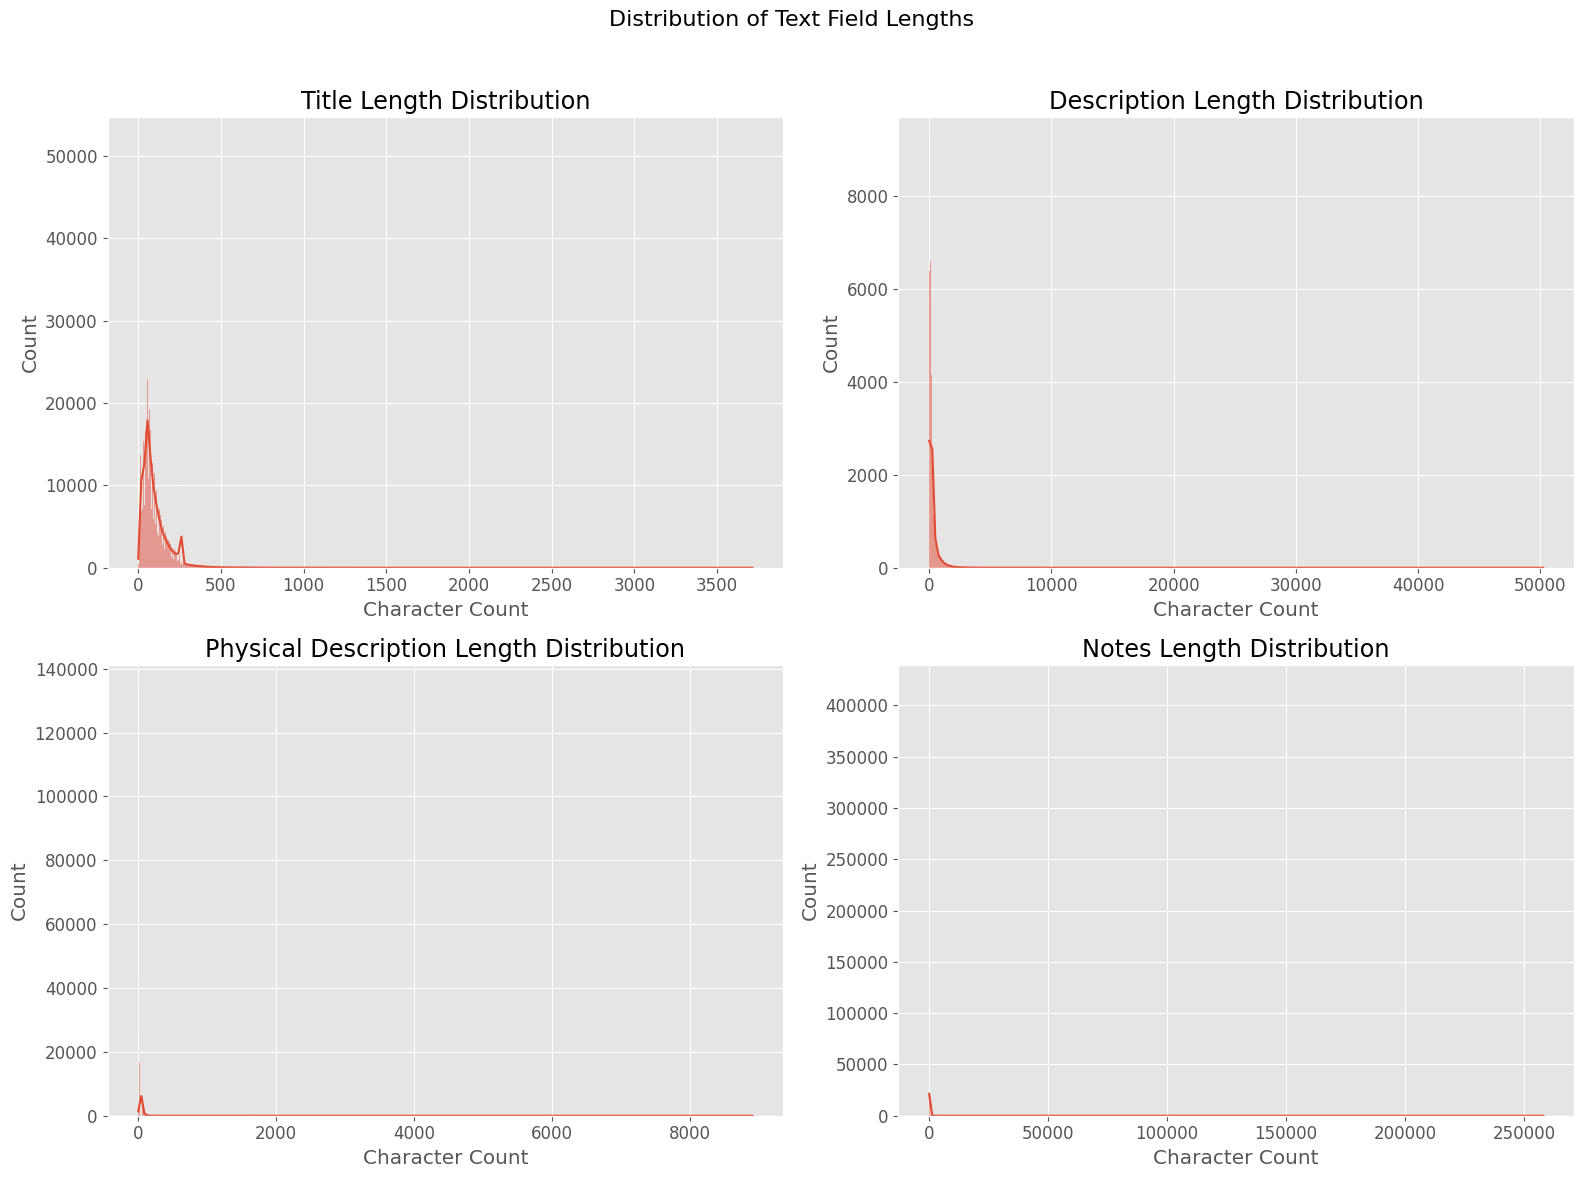

In [5]:
# Convert text statistics to pandas for visualization
text_stats_pd = text_stats.toPandas()

# Create a figure with multiple subplots for histograms of text lengths
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Distribution of Text Field Lengths', fontsize=16)

# Plot histograms with KDE for different text fields
sns.histplot(text_stats_pd['title_length'].dropna(), kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Title Length Distribution')
axes[0, 0].set_xlabel('Character Count')

sns.histplot(text_stats_pd['description_length'].dropna(), kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Description Length Distribution')
axes[0, 1].set_xlabel('Character Count')

sns.histplot(text_stats_pd['physical_desc_length'].dropna(), kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Physical Description Length Distribution')
axes[1, 0].set_xlabel('Character Count')

sns.histplot(text_stats_pd['notes_length'].dropna(), kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Notes Length Distribution')
axes[1, 1].set_xlabel('Character Count')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

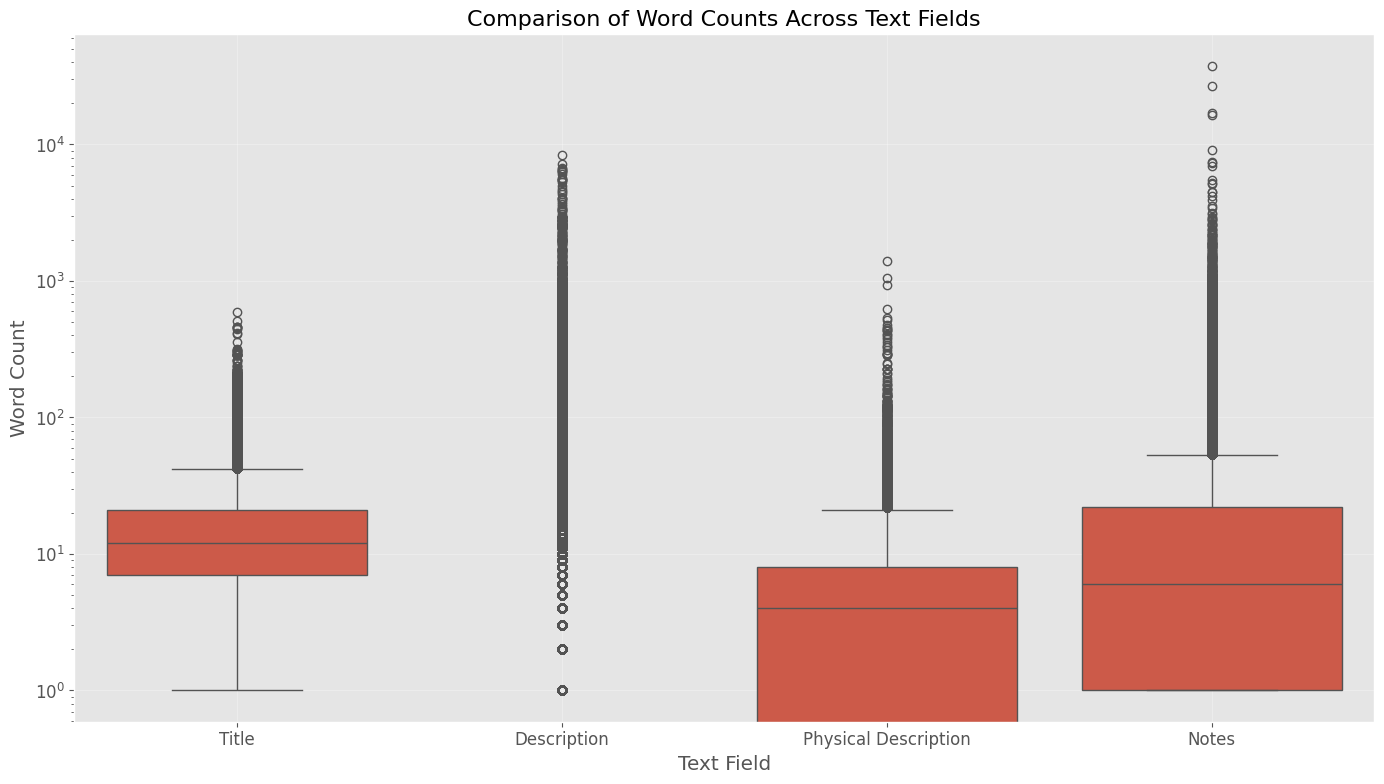

In [6]:
# Create boxplots to compare word counts across different text fields
# Prepare data for boxplot
box_data = pd.DataFrame({
    'Title': text_stats_pd['title_word_count'],
    'Description': text_stats_pd['description_word_count'],
    'Physical Description': text_stats_pd['physical_desc_word_count'],
    'Notes': text_stats_pd['notes_word_count']
})

# Melt the dataframe for better visualization with seaborn
melted_data = pd.melt(box_data, var_name='Text Field', value_name='Word Count')

plt.figure(figsize=(14, 8))
sns.boxplot(x='Text Field', y='Word Count', data=melted_data)
plt.title('Comparison of Word Counts Across Text Fields', fontsize=16)
plt.yscale('log')  # Use log scale for better visualization if there are outliers
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Text Complexity Analysis

Let's analyze the complexity and readability of the text fields using metrics such as:
- Average word length
- Lexical diversity (ratio of unique words to total words)
- Presence of specialized vocabulary
- Sentiment patterns

In [7]:
# Calculate text complexity metrics
complexity_df = df.select(
    "id",
    "title",
    "description",
    "physicalDescription",
    "note_contents"
)

# Define UDF for calculating average word length
@F.udf(returnType=FloatType())
def avg_word_length(text):
    if not text or len(text.strip()) == 0:
        return None
    words = [w for w in text.split() if len(w.strip()) > 0]
    if not words:
        return 0.0
    return sum(len(word) for word in words) / len(words)

# Define UDF for calculating lexical diversity (unique words / total words)
@F.udf(returnType=FloatType())
def lexical_diversity(text):
    if not text or len(text.strip()) == 0:
        return None
    words = [w.lower() for w in text.split() if len(w.strip()) > 0]
    if not words:
        return 0.0
    return len(set(words)) / len(words)

# Apply the UDFs to calculate complexity metrics
complexity_analysis = complexity_df.select(
    "id",
    avg_word_length("title").alias("title_avg_word_length"),
    lexical_diversity("title").alias("title_lexical_diversity"),
    
    avg_word_length("description").alias("description_avg_word_length"),
    lexical_diversity("description").alias("description_lexical_diversity"),
    
    avg_word_length("physicalDescription").alias("physical_desc_avg_word_length"),
    lexical_diversity("physicalDescription").alias("physical_desc_lexical_diversity"),
    
    avg_word_length("note_contents").alias("notes_avg_word_length"),
    lexical_diversity("note_contents").alias("notes_lexical_diversity")
)

# Show summary of complexity metrics
complexity_analysis.summary().show()

+-------+--------+---------------------+-----------------------+---------------------------+-----------------------------+-----------------------------+-------------------------------+---------------------+-----------------------+
|summary|      id|title_avg_word_length|title_lexical_diversity|description_avg_word_length|description_lexical_diversity|physical_desc_avg_word_length|physical_desc_lexical_diversity|notes_avg_word_length|notes_lexical_diversity|
+-------+--------+---------------------+-----------------------+---------------------------+-----------------------------+-----------------------------+-------------------------------+---------------------+-----------------------+
|  count| 1167444|              1167201|                1167201|                     236732|                       236732|                       862781|                         862781|               749352|                 749352|
|   mean|    NULL|   5.7594313989205554|     0.9424028574705681|          6.

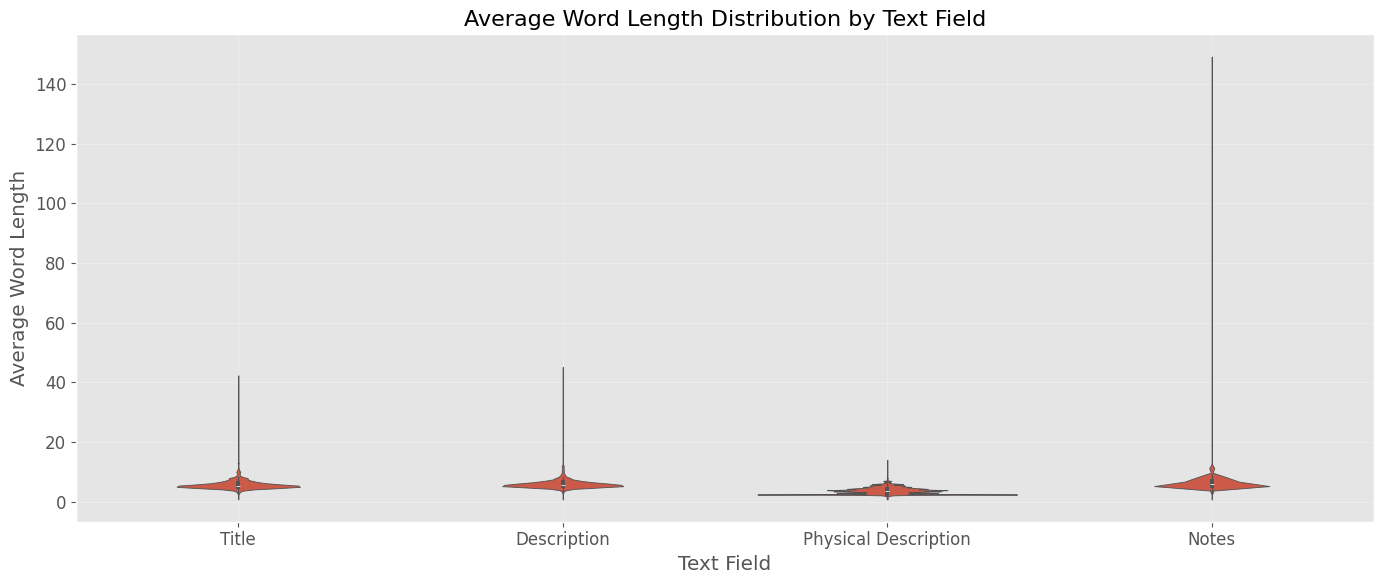

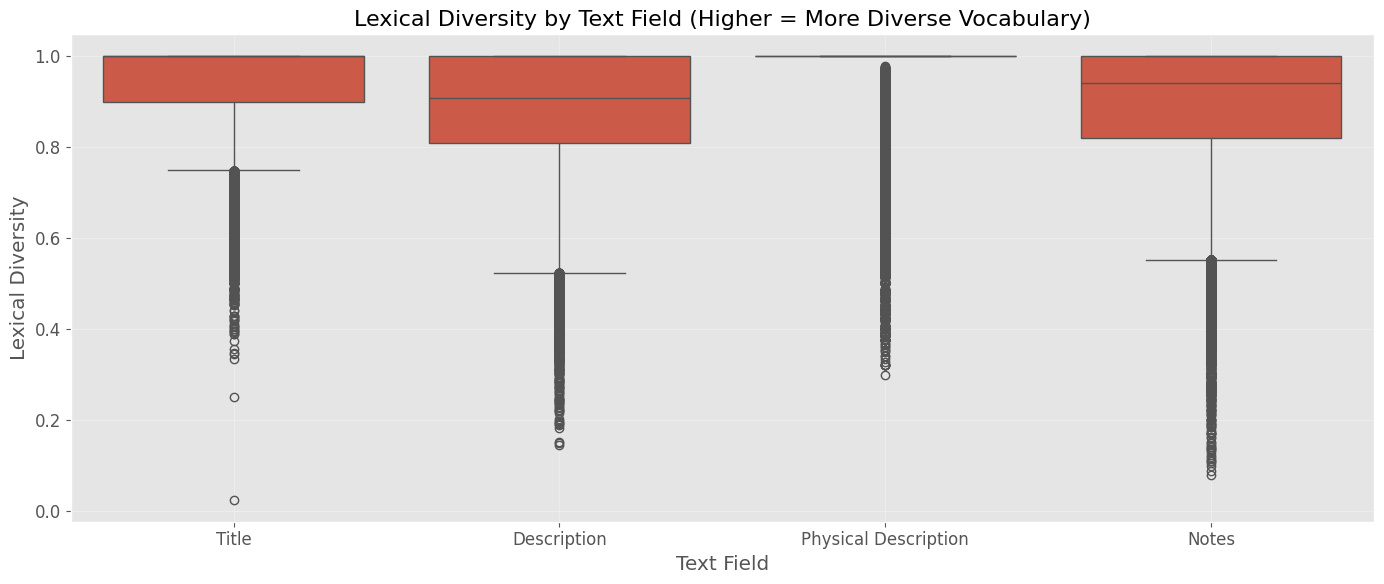

In [8]:
# Visualization of text complexity metrics
complexity_pd = complexity_analysis.toPandas()

# Plot average word length comparison across text fields
plt.figure(figsize=(14, 6))
avg_word_data = pd.DataFrame({
    'Title': complexity_pd['title_avg_word_length'],
    'Description': complexity_pd['description_avg_word_length'],
    'Physical Description': complexity_pd['physical_desc_avg_word_length'],
    'Notes': complexity_pd['notes_avg_word_length']
})
avg_word_melted = pd.melt(avg_word_data, var_name='Text Field', value_name='Average Word Length')

sns.violinplot(x='Text Field', y='Average Word Length', data=avg_word_melted)
plt.title('Average Word Length Distribution by Text Field', fontsize=16)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot lexical diversity comparison across text fields
plt.figure(figsize=(14, 6))
lex_div_data = pd.DataFrame({
    'Title': complexity_pd['title_lexical_diversity'],
    'Description': complexity_pd['description_lexical_diversity'],
    'Physical Description': complexity_pd['physical_desc_lexical_diversity'],
    'Notes': complexity_pd['notes_lexical_diversity']
})
lex_div_melted = pd.melt(lex_div_data, var_name='Text Field', value_name='Lexical Diversity')

sns.boxplot(x='Text Field', y='Lexical Diversity', data=lex_div_melted)
plt.title('Lexical Diversity by Text Field (Higher = More Diverse Vocabulary)', fontsize=16)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Term Frequency Analysis

Let's explore the most common words and phrases in different text fields to understand the content better.

In [ ]:
# Term frequency analysis for the description field
from pyspark.ml.feature import Tokenizer, CountVectorizer, StopWordsRemover, IDF
from pyspark.sql.functions import explode, col

# Select non-empty descriptions
descriptions_df = df.filter(F.length("description") > 0).select("id", "description")

# Tokenize text
tokenizer = Tokenizer(inputCol="description", outputCol="words")
words_df = tokenizer.transform(descriptions_df)

# Remove stop words
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
filtered_df = remover.transform(words_df)

# Create a custom UDF to filter out numbers and short tokens
@F.udf(returnType=ArrayType(StringType()))
def clean_tokens(tokens):
    if not tokens:
        return []
    return [token.lower() for token in tokens if len(token) > 2 and not token.isdigit()]

cleaned_df = filtered_df.withColumn("clean_words", clean_tokens(col("filtered_words")))

# Calculate term frequencies
cv = CountVectorizer(inputCol="clean_words", outputCol="term_freq", minDF=5, vocabSize=10000)
cv_model = cv.fit(cleaned_df)
term_freq_df = cv_model.transform(cleaned_df)

# Extract vocabulary from the CountVectorizerModel
vocab = cv_model.vocabulary

# Explode the term_freq vector to get counts for each term
@F.udf(returnType=ArrayType(StructType([
    StructField("term", StringType()),
    StructField("count", IntegerType())
])))
def extract_term_counts(vector, vocab_list):
    indices = vector.indices.tolist()
    values = vector.values.tolist()
    return [(vocab_list[idx], int(val)) for idx, val in zip(indices, values)]

# Apply UDF to extract term counts
term_counts_df = term_freq_df.withColumn(
    "term_counts", 
    extract_term_counts(col("term_freq"), F.array([F.lit(t) for t in vocab]))
)

# Explode the array to get individual term-count pairs
exploded_df = term_counts_df.select(
    "id",
    explode("term_counts").alias("term_count")
)

# Extract term and count from the struct
term_count_df = exploded_df.select(
    "id", 
    col("term_count.term").alias("term"),
    col("term_count.count").alias("count")
)

# Group by term and sum counts
term_totals = term_count_df.groupBy("term").agg(F.sum("count").alias("total_count"))

# Get top 30 terms
top_terms = term_totals.orderBy(col("total_count").desc()).limit(30)
top_terms_pd = top_terms.toPandas()

# Plot top terms
plt.figure(figsize=(14, 8))
sns.barplot(x="term", y="total_count", data=top_terms_pd)
plt.title('Top 30 Terms in Description Field', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Term')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [ ]:
# Generate a word cloud visualization
try:
    from wordcloud import WordCloud
    
    # Create a dictionary from the top terms dataframe
    word_freq = dict(zip(top_terms_pd['term'], top_terms_pd['total_count']))
    
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', 
                         max_words=100, max_font_size=100, scale=3,
                         random_state=42).generate_from_frequencies(word_freq)
    
    plt.figure(figsize=(16, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Description Field Terms', fontsize=16)
    plt.tight_layout()
    plt.show()
except ImportError:
    print("WordCloud package not available. Install using: pip install wordcloud")

## N-gram Analysis

Let's analyze common phrases (bigrams and trigrams) to identify multi-word expressions and common patterns in the text.

In [ ]:
# N-gram analysis to identify common phrases in descriptions
from pyspark.ml.feature import NGram

# Add bigrams (2-word phrases)
bigram = NGram(n=2, inputCol="filtered_words", outputCol="bigrams")
bigram_df = bigram.transform(filtered_df)

# Add trigrams (3-word phrases)
trigram = NGram(n=3, inputCol="filtered_words", outputCol="trigrams")
ngram_df = trigram.transform(bigram_df)

# Function to get top n-grams
def get_top_ngrams(df, ngram_col, n=20):
    # Explode the n-grams to get individual entries
    exploded_df = df.select(explode(col(ngram_col)).alias("ngram"))
    
    # Count the occurrences of each n-gram
    ngram_counts = exploded_df.groupBy("ngram").count().orderBy(col("count").desc())
    
    # Get top n n-grams
    return ngram_counts.limit(n).toPandas()

# Get top bigrams
top_bigrams = get_top_ngrams(ngram_df, "bigrams")

# Get top trigrams
top_trigrams = get_top_ngrams(ngram_df, "trigrams")

# Plot top bigrams
plt.figure(figsize=(14, 6))
sns.barplot(x="ngram", y="count", data=top_bigrams)
plt.title('Top 20 Bigrams (2-word phrases) in Descriptions', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot top trigrams
plt.figure(figsize=(14, 6))
sns.barplot(x="ngram", y="count", data=top_trigrams)
plt.title('Top 20 Trigrams (3-word phrases) in Descriptions', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Topic Modeling

Let's use Latent Dirichlet Allocation (LDA) to discover abstract topics in the collection.

In [ ]:
# Topic modeling using LDA (Latent Dirichlet Allocation)
from pyspark.ml.clustering import LDA

# Prepare the data for LDA - using the term frequency data from previous cell
# Filter out documents with empty word lists to avoid errors
lda_input = term_freq_df.filter(F.size("clean_words") > 0)

# Number of topics to extract
num_topics = 10

# Create an LDA model
lda = LDA(k=num_topics, maxIter=10, featuresCol="term_freq")
lda_model = lda.fit(lda_input)

# Get topics and their terms
topics = lda_model.describeTopics()
topics.show(truncate=False)

# Convert topics to a more interpretable format
@F.udf(returnType=ArrayType(StringType()))
def map_term_indices_to_words(termIndices, vocabulary):
    return [vocabulary[idx] for idx in termIndices]

# Apply UDF to get terms for each topic
topics_with_terms = topics.withColumn(
    "terms", 
    map_term_indices_to_words(
        col("termIndices"), 
        F.array([F.lit(word) for word in vocab])
    )
)

# Show topics with their terms
topics_with_terms.select("topic", "terms", "termWeights").show(truncate=100)

In [ ]:
# Visualize topics and their most important terms
topics_df = topics_with_terms.toPandas()

# Create a function to plot top terms for each topic
def plot_topics(topics_df, num_terms=5):
    topics_to_plot = min(6, len(topics_df))  # Plot at most 6 topics at a time
    fig, axes = plt.subplots(topics_to_plot, 1, figsize=(12, 3*topics_to_plot))
    
    if topics_to_plot == 1:
        axes = [axes]  # Make sure axes is always a list
        
    for i, (ax, (_, row)) in enumerate(zip(axes, topics_df.iterrows())):
        # Get top terms and their weights
        terms = row['terms'][:num_terms]
        weights = row['termWeights'][:num_terms]
        
        # Create horizontal bar chart
        ax.barh(range(len(terms)), weights, align='center')
        ax.set_yticks(range(len(terms)))
        ax.set_yticklabels(terms)
        ax.set_title(f'Topic {row["topic"]}', fontsize=14)
        ax.set_xlabel('Term Weight')
    
    plt.tight_layout()
    plt.show()

# Plot the top topics
plot_topics(topics_df)

# If there are more than 6 topics, plot the rest
if len(topics_df) > 6:
    plot_topics(topics_df.iloc[6:])

## Text Field Correlation Analysis

Let's explore relationships between different text fields.

In [ ]:
# Correlation analysis between text fields
# We'll create a correlation matrix of text length, complexity, and diversity metrics

# Prepare correlation data
corr_data = text_stats_pd.join(
    complexity_pd.set_index('id'),
    on='id', how='inner', rsuffix='_complexity'
)

# Select numerical columns for correlation
corr_columns = [
    'title_length', 'title_word_count',
    'description_length', 'description_word_count',
    'physical_desc_length', 'physical_desc_word_count',
    'notes_length', 'notes_word_count',
    'title_avg_word_length', 'title_lexical_diversity',
    'description_avg_word_length', 'description_lexical_diversity',
    'physical_desc_avg_word_length', 'physical_desc_lexical_diversity',
    'notes_avg_word_length', 'notes_lexical_diversity'
]

# Calculate correlation matrix
corr_matrix = corr_data[corr_columns].corr()

# Visualize correlation matrix as a heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(
    corr_matrix,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    linewidths=0.5,
    vmin=-1,
    vmax=1
)
plt.title('Correlation Matrix of Text Field Metrics', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Named Entity Recognition

Let's extract named entities (people, places, organizations, dates, etc.) from the text fields to understand what kinds of entities are mentioned in the collection.

In [ ]:
# Named Entity Recognition using spaCy
# Note: You may need to install spaCy and download the English model:
# !pip install spacy
# !python -m spacy download en_core_web_sm

try:
    import spacy
    from collections import Counter
    import pandas as pd
    
    # Load spaCy model
    try:
        nlp = spacy.load('en_core_web_sm')
        
        # Sample some descriptions for NER (for performance reasons)
        sample_descriptions = df.filter(F.length('description') > 50) \
                               .select('description') \
                               .limit(100) \
                               .toPandas()
        
        # Extract entities
        all_entities = []
        entity_texts = []
        entity_labels = []
        
        for desc in sample_descriptions['description']:
            if pd.notna(desc) and desc.strip():
                doc = nlp(desc[:10000])  # Limit text size for processing efficiency
                for ent in doc.ents:
                    all_entities.append((ent.text, ent.label_))
                    entity_texts.append(ent.text)
                    entity_labels.append(ent.label_)
        
        # Count entity types
        entity_type_counts = Counter([ent[1] for ent in all_entities])
        entity_counts_df = pd.DataFrame({
            'Entity Type': list(entity_type_counts.keys()),
            'Count': list(entity_type_counts.values())
        }).sort_values('Count', ascending=False)
        
        # Create entity DataFrame
        entities_df = pd.DataFrame({
            'text': entity_texts,
            'label': entity_labels
        })
        
        # Plot entity type distribution
        plt.figure(figsize=(12, 6))
        sns.barplot(x='Entity Type', y='Count', data=entity_counts_df)
        plt.title('Named Entity Types in Description Field', fontsize=16)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
        
        # Show most common entities by type
        most_common_entities = {}
        for entity_type in entities_df['label'].unique():
            entities_of_type = entities_df[entities_df['label'] == entity_type]['text']
            most_common = Counter(entities_of_type).most_common(5)
            if most_common:
                most_common_entities[entity_type] = most_common
        
        for entity_type, common_entities in most_common_entities.items():
            print(f"\nMost common {entity_type} entities:")
            for entity, count in common_entities:
                print(f"  - {entity}: {count}")
    except Exception as e:
        print(f"Error loading spaCy model: {e}")
        print("Please install the English model with: python -m spacy download en_core_web_sm")
        
except ImportError:
    print("spaCy is not installed. Install using: pip install spacy")

## Novel Text Characterization Approaches

Let's explore some innovative approaches to characterize the text content:

In [ ]:
# 1. Sentiment Analysis - Exploring emotional tone of text fields
try:
    from textblob import TextBlob
    import pandas as pd
    import numpy as np
    
    # Function to calculate sentiment polarity and subjectivity
    def get_sentiment(text):
        if pd.isna(text) or text.strip() == '':
            return (np.nan, np.nan)  # Return NaN for empty text
        blob = TextBlob(text)
        return (blob.sentiment.polarity, blob.sentiment.subjectivity)
    
    # Sample some descriptions for sentiment analysis
    sample_data = df.select(
        'id', 'title', 'description', 'physicalDescription', 'note_contents'
    ).limit(500).toPandas()
    
    # Calculate sentiment scores for each field
    sentiment_data = []
    for _, row in sample_data.iterrows():
        record = {'id': row['id']}
        
        # Process each text field
        for field in ['title', 'description', 'physicalDescription', 'note_contents']:
            if pd.notna(row[field]) and row[field].strip():
                polarity, subjectivity = get_sentiment(row[field])
                record[f'{field}_polarity'] = polarity
                record[f'{field}_subjectivity'] = subjectivity
                
        sentiment_data.append(record)
    
    # Create DataFrame with sentiment scores
    sentiment_df = pd.DataFrame(sentiment_data)
    
    # Plot sentiment polarity distribution across different fields
    plt.figure(figsize=(14, 6))
    for field in ['title', 'description', 'physicalDescription', 'note_contents']:
        col = f'{field}_polarity'
        if col in sentiment_df.columns:
            sns.kdeplot(sentiment_df[col].dropna(), label=field)
    
    plt.title('Sentiment Polarity Distribution Across Text Fields', fontsize=16)
    plt.xlabel('Polarity (Negative → Positive)')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axvline(x=0, color='gray', linestyle='--')
    plt.tight_layout()
    plt.show()
    
    # Plot subjectivity comparison boxplot
    plt.figure(figsize=(14, 6))
    subj_data = {
        field: sentiment_df[f'{field}_subjectivity'].dropna() 
        for field in ['title', 'description', 'physicalDescription', 'note_contents'] 
        if f'{field}_subjectivity' in sentiment_df.columns
    }
    plt.boxplot([data for field, data in subj_data.items()], labels=list(subj_data.keys()))
    plt.title('Text Subjectivity Comparison (Higher = More Subjective)', fontsize=16)
    plt.ylabel('Subjectivity Score')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
except ImportError:
    print("TextBlob not installed. Install with: pip install textblob")

In [ ]:
# 2. Text Readability and Complexity Metrics
try:
    import textstat
    
    # Sample data for readability analysis
    readability_sample = df.filter(F.length('description') > 100).select('id', 'description').limit(200).toPandas()
    
    # Calculate readability scores
    readability_data = []
    for _, row in readability_sample.iterrows():
        if pd.notna(row['description']) and len(row['description'].strip()) > 0:
            text = row['description']
            readability_data.append({
                'id': row['id'],
                'flesch_reading_ease': textstat.flesch_reading_ease(text),
                'flesch_kincaid_grade': textstat.flesch_kincaid_grade(text),
                'smog_index': textstat.smog_index(text),
                'coleman_liau_index': textstat.coleman_liau_index(text),
                'automated_readability_index': textstat.automated_readability_index(text),
                'dale_chall_readability_score': textstat.dale_chall_readability_score(text),
                'text_standard': textstat.text_standard(text, float_output=True)
            })
    
    # Create DataFrame with readability metrics
    readability_df = pd.DataFrame(readability_data)
    
    # Calculate summary statistics
    readability_stats = readability_df.describe()
    display(readability_stats)
    
    # Plot distribution of reading level
    plt.figure(figsize=(14, 6))
    sns.histplot(readability_df['text_standard'].dropna(), kde=True, bins=15)
    plt.title('Distribution of Reading Grade Level in Description Text', fontsize=16)
    plt.xlabel('US Grade Level')
    plt.ylabel('Count')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
except ImportError:
    print("TextStat not installed. Install with: pip install textstat")

## Text Clustering and Collection Segmentation

Let's segment the collection based on text content to identify natural groupings.

In [ ]:
# Text clustering using embeddings and dimensionality reduction
from pyspark.ml.feature import Word2Vec
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# Use the cleaned word lists from earlier
# Train Word2Vec model to get document embeddings
w2v = Word2Vec(
    vectorSize=100,
    minCount=2,
    inputCol="clean_words",
    outputCol="document_vector"
)

# Train the model and transform the data - only using documents with words
valid_docs = cleaned_df.filter(F.size("clean_words") > 0)
w2v_model = w2v.fit(valid_docs)
doc_vectors = w2v_model.transform(valid_docs)

# Convert to pandas for visualization
doc_vectors_pd = doc_vectors.select("id", "document_vector").limit(500).toPandas()

# Convert vectors to numpy arrays for dimensionality reduction
vectors = np.array(doc_vectors_pd['document_vector'].tolist())

# Apply t-SNE for dimensionality reduction
if len(vectors) > 0:
    tsne = TSNE(n_components=2, random_state=42)
    vectors_2d = tsne.fit_transform(vectors)
    
    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=5, random_state=42)
    clusters = kmeans.fit_predict(vectors)
    
    # Create visualization dataframe
    viz_df = pd.DataFrame({
        'id': doc_vectors_pd['id'],
        'x': vectors_2d[:, 0],
        'y': vectors_2d[:, 1],
        'cluster': clusters
    })
    
    # Visualize clusters
    plt.figure(figsize=(12, 8))
    scatter = sns.scatterplot(x='x', y='y', data=viz_df, hue='cluster', palette='viridis', alpha=0.7)
    plt.title('Document Clustering based on Text Content', fontsize=16)
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.legend(title='Cluster')
    plt.tight_layout()
    plt.show()

## Temporal Pattern Analysis

Let's analyze if the text data contains temporal references and patterns.

In [ ]:
# Extract and analyze temporal references in text
try:
    import re
    import pandas as pd
    from collections import Counter
    
    # Sample data for temporal analysis
    temporal_sample = df.select('id', 'description', 'note_contents').limit(1000).toPandas()
    
    # Regular expressions for finding years and centuries
    year_pattern = r'\b1[0-9]{3}\b|\b20[0-9]{2}\b'  # Years from 1000-2099
    century_pattern = r'\b(?:1[0-9]|20)th century\b|\b(?:1[0-9]|20)st century\b'  # 10th-21st century
    decade_pattern = r'\b(?:1[0-9]|20)[0-9]0s\b'  # 1000s-2090s decades
    
    # Function to extract temporal references
    def extract_temporal_refs(text):
        if pd.isna(text) or text.strip() == '':
            return [], [], []
            
        years = re.findall(year_pattern, text)
        centuries = re.findall(century_pattern, text)
        decades = re.findall(decade_pattern, text)
        
        return years, centuries, decades
    
    # Collect all temporal references
    all_years = []
    all_centuries = []
    all_decades = []
    
    # Process description and notes fields
    for _, row in temporal_sample.iterrows():
        for field in ['description', 'note_contents']:
            if pd.notna(row[field]) and row[field].strip():
                years, centuries, decades = extract_temporal_refs(row[field])
                all_years.extend(years)
                all_centuries.extend(centuries)
                all_decades.extend(decades)
    
    # Convert years to integers for histogram
    year_ints = [int(y) for y in all_years if y.isdigit()]
    
    # Plot distribution of years mentioned
    if year_ints:
        plt.figure(figsize=(14, 6))
        sns.histplot(year_ints, bins=30, kde=True)
        plt.title('Distribution of Years Mentioned in Text', fontsize=16)
        plt.xlabel('Year')
        plt.ylabel('Frequency')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # Show most common temporal references
    print("\nMost common years mentioned:")
    for year, count in Counter(all_years).most_common(10):
        print(f"  - {year}: {count}")
        
    print("\nMost common centuries mentioned:")
    for century, count in Counter(all_centuries).most_common(5):
        print(f"  - {century}: {count}")
        
    print("\nMost common decades mentioned:")
    for decade, count in Counter(all_decades).most_common(5):
        print(f"  - {decade}: {count}")
except Exception as e:
    print(f"Error in temporal analysis: {e}")

## Contextual Text Field Analysis

Let's explore how different text fields complement each other and provide context.

In [ ]:
# Analyzing how different text fields complement each other
# Calculate overlap and uniqueness between fields

# Function to calculate text overlap metrics
def calculate_text_overlap(row, field1, field2):
    if pd.isna(row[field1]) or pd.isna(row[field2]) or len(row[field1].strip()) == 0 or len(row[field2].strip()) == 0:
        return np.nan, np.nan
    
    # Tokenize both fields
    words1 = set(row[field1].lower().split())
    words2 = set(row[field2].lower().split())
    
    # Calculate Jaccard similarity (intersection over union)
    intersection = words1.intersection(words2)
    union = words1.union(words2)
    jaccard = len(intersection) / len(union) if len(union) > 0 else 0
    
    # Calculate percentage of unique words in field2 not in field1
    unique_percentage = len(words2 - words1) / len(words2) if len(words2) > 0 else 0
    
    return jaccard, unique_percentage

# Sample data for overlap analysis
sample_fields = df.select(
    'id', 'title', 'description', 'physicalDescription', 'note_contents'
).filter(
    (F.length('title') > 0) & 
    (F.length('description') > 0) & 
    (F.length('physicalDescription') > 0)
).limit(200).toPandas()

# Calculate overlap metrics
overlap_data = []
for _, row in sample_fields.iterrows():
    # Title-Description overlap
    title_desc_jaccard, title_desc_unique = calculate_text_overlap(row, 'title', 'description')
    
    # Description-Physical overlap
    desc_phys_jaccard, desc_phys_unique = calculate_text_overlap(row, 'description', 'physicalDescription')
    
    # Title-Physical overlap
    title_phys_jaccard, title_phys_unique = calculate_text_overlap(row, 'title', 'physicalDescription')
    
    overlap_data.append({
        'id': row['id'],
        'title_desc_similarity': title_desc_jaccard,
        'title_desc_uniqueness': title_desc_unique,
        'desc_phys_similarity': desc_phys_jaccard,
        'desc_phys_uniqueness': desc_phys_unique,
        'title_phys_similarity': title_phys_jaccard,
        'title_phys_uniqueness': title_phys_unique
    })

overlap_df = pd.DataFrame(overlap_data)

# Plot similarity between fields
plt.figure(figsize=(12, 6))
similarity_data = pd.DataFrame({
    'Title-Description': overlap_df['title_desc_similarity'].dropna(),
    'Description-Physical': overlap_df['desc_phys_similarity'].dropna(),
    'Title-Physical': overlap_df['title_phys_similarity'].dropna()
})
similarity_melted = pd.melt(similarity_data, var_name='Field Pair', value_name='Jaccard Similarity')

sns.boxplot(x='Field Pair', y='Jaccard Similarity', data=similarity_melted)
plt.title('Text Overlap Between Different Fields', fontsize=16)
plt.ylabel('Similarity (0=No Overlap, 1=Identical)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot uniqueness between fields
plt.figure(figsize=(12, 6))
uniqueness_data = pd.DataFrame({
    'Description vs Title': overlap_df['title_desc_uniqueness'].dropna(),
    'Physical Description vs Description': overlap_df['desc_phys_uniqueness'].dropna(),
    'Physical Description vs Title': overlap_df['title_phys_uniqueness'].dropna()
})
uniqueness_melted = pd.melt(uniqueness_data, var_name='Field Comparison', value_name='Unique Information')

sns.boxplot(x='Field Comparison', y='Unique Information', data=uniqueness_melted)
plt.title('Unique Content Added by Each Field', fontsize=16)
plt.ylabel('Proportion of Unique Words (0=All Duplicated, 1=All Unique)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Conclusions and Insights

Based on our text analysis, here are some key findings:

1. **Text Length Distribution**: We've examined how text length varies across different fields, helping understand the relative information density in each field.

2. **Text Complexity**: We've measured lexical diversity and average word length to gauge the complexity of language used in different text fields.

3. **Common Terms and Phrases**: Through term frequency and n-gram analysis, we've identified the most common terms and phrases that characterize the collection.

4. **Topic Modeling**: We've discovered latent topics in the collection, revealing thematic patterns that might not be explicitly categorized.

5. **Named Entity Recognition**: We've identified people, places, organizations and other entities mentioned in the texts, providing insight into what the collection references.

6. **Sentiment and Subjectivity**: We've analyzed the emotional tone and subjectivity of different text fields.

7. **Temporal References**: We've extracted and analyzed time-related information to understand the historical periods referenced in the collection.

8. **Text Field Complementarity**: We've examined how different text fields complement each other by measuring overlap and unique information.

These analyses provide a rich understanding of the textual content in the works collection, which can inform further research, curation decisions, and search functionality improvements.